In [18]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import re

# رابط صفحة Wikipedia
url = "https://en.wikipedia.org/wiki/Hajj"
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

# إيجاد جميع جداول wikitable
tables = soup.find_all('table', {'class':'wikitable'})

# اختيار جدول أعداد الحجاج
html_str = str(tables[1])  # جرب تغييره إذا الجدول مش الصح
df = pd.read_html(StringIO(html_str))[0]

# تنظيف أسماء الأعمدة
df.columns = [c.strip() for c in df.columns]

# تنظيف الملاحظات المرجعية من الأعمدة النصية
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).apply(lambda x: re.sub(r'\[\d+\]', '', x).strip())

# حذف الصفوف اللي فيها Gregorian year غير رقمي (مثل "1950s")
df = df[df['Gregorian year'].str.match(r'^\d{4}$')]

# تحويل الأعمدة الرقمية
df['Gregorian year'] = pd.to_numeric(df['Gregorian year'])
df['Hijri year'] = pd.to_numeric(df['Hijri year'], errors='coerce')

for col in ['Local pilgrims', 'Foreign pilgrims', 'Total']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].str.replace(r'[^\d]', '', regex=True), errors='coerce')

# حفظ الملف النهائي Excel
# حفظ الملف النهائي Excel بدون encoding
df.to_excel("Hajj_pilgrims_final.xlsx", index=False)

print("تم إنشاء الملف النهائي بنجاح: Hajj_pilgrims_final.xlsx")



تم إنشاء الملف النهائي بنجاح: Hajj_pilgrims_final.xlsx


In [19]:
from google.colab import files
files.download("Hajj_pilgrims_final.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
print(df)

    Gregorian year  Hijri year  Local pilgrims  Foreign pilgrims      Total
0             1920      1338.0             NaN           58584.0        NaN
1             1921      1339.0             NaN           57255.0        NaN
2             1922      1340.0             NaN           56319.0        NaN
3             1950      1369.0             NaN          100000.0        NaN
8             1989      1409.0             NaN          774600.0        NaN
9             1990      1410.0             NaN          827200.0        NaN
10            1991      1411.0             NaN          720100.0        NaN
11            1992      1412.0             NaN         1015700.0        NaN
12            1993      1413.0             NaN          992800.0        NaN
13            1994      1414.0             NaN          997400.0        NaN
14            1995      1415.0             NaN         1046307.0        NaN
15            1996      1416.0        784769.0         1080465.0  1865234.0
16          

In [48]:
#عايزه اشوف عدد الخلايا الفاضيه
print(df.isnull().sum())


Gregorian year          0
Hijri year              0
Local pilgrims         13
Foreign pilgrims        2
Total                  12
Gregorian_year_date     0
Gregorian year_date     0
dtype: int64


In [49]:
# استبدال كل القيم المفقودة 0 فقط للأعمدة الرقمية
cols_numeric = ['Local pilgrims', 'Foreign pilgrims', 'Total']
df[cols_numeric] = df[cols_numeric].fillna(0)
print(df[cols_numeric].isnull().sum())


Local pilgrims      0
Foreign pilgrims    0
Total               0
dtype: int64


In [61]:
df.describe()

,Gregorian year,Local pilgrims,Foreign pilgrims,Total,Gregorian_year_date
count,41.000000,4.100000e+01,4.100000e+01,4.100000e+01,41
mean,1998.853659,4.160427e+05,1.130111e+06,1.402254e+06,1998-11-08 16:23:24.878048768
min,1920.000000,0.000000e+00,0.000000e+00,0.000000e+00,1920-01-01 00:00:00
25%,1995.000000,0.000000e+00,8.272000e+05,0.000000e+00,1995-01-01 00:00:00
50%,2005.000000,4.730040e+05,1.325372e+06,1.845045e+06,2005-01-01 00:00:00
75%,2014.000000,6.961850e+05,1.611310e+06,2.130594e+06,2014-01-01 00:00:00
max,2024.000000,1.408641e+06,1.855027e+06,3.161573e+06,2024-01-01 00:00:00
std,25.793954,3.808154e+05,5.886498e+05,1.084061e+06,NaN


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, 0 to 44
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gregorian year    41 non-null     int64  
 1   Hijri year        41 non-null     float64
 2   Local pilgrims    28 non-null     float64
 3   Foreign pilgrims  39 non-null     float64
 4   Total             29 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.9 KB


In [25]:
df.shape

(41, 5)

In [42]:
# تحويل عمود Gregorian year إلى datetime
df['Gregorian_year_date'] = pd.to_datetime(df['Gregorian year'], format='%Y', errors='coerce')
print(df['Gregorian year_date'].head(10))


0    1920-01-01
1    1921-01-01
2    1922-01-01
3    1950-01-01
8    1989-01-01
9    1990-01-01
10   1991-01-01
11   1992-01-01
12   1993-01-01
13   1994-01-01
Name: Gregorian year_date, dtype: datetime64[ns]


In [58]:
# تجميع حسب Local pilgrims و Gregorian_year_date وحساب متوسط Total
df_grouped = df.groupby(['Local pilgrims', 'Gregorian_year_date'])['Total'].mean().reset_index()

# عرض النتيجة
print(df_grouped.head())


   Local pilgrims Gregorian_year_date  Total
0             0.0          1920-01-01    0.0
1             0.0          1921-01-01    0.0
2             0.0          1922-01-01    0.0
3             0.0          1950-01-01    0.0
4             0.0          1989-01-01    0.0


In [ ]:
# حذف عمود 'Hijri year' نهائياً
df = df.drop(columns=['Hijri year','Gregorian year_date'])

# التأكد
print(df.head())


In [ ]:
df = df.drop(columns=['Gregorian year_date'])


In [56]:
print(df.head())

   Gregorian year  Local pilgrims  Foreign pilgrims  Total Gregorian_year_date
0            1920             0.0           58584.0    0.0          1920-01-01
1            1921             0.0           57255.0    0.0          1921-01-01
2            1922             0.0           56319.0    0.0          1922-01-01
3            1950             0.0          100000.0    0.0          1950-01-01
8            1989             0.0          774600.0    0.0          1989-01-01


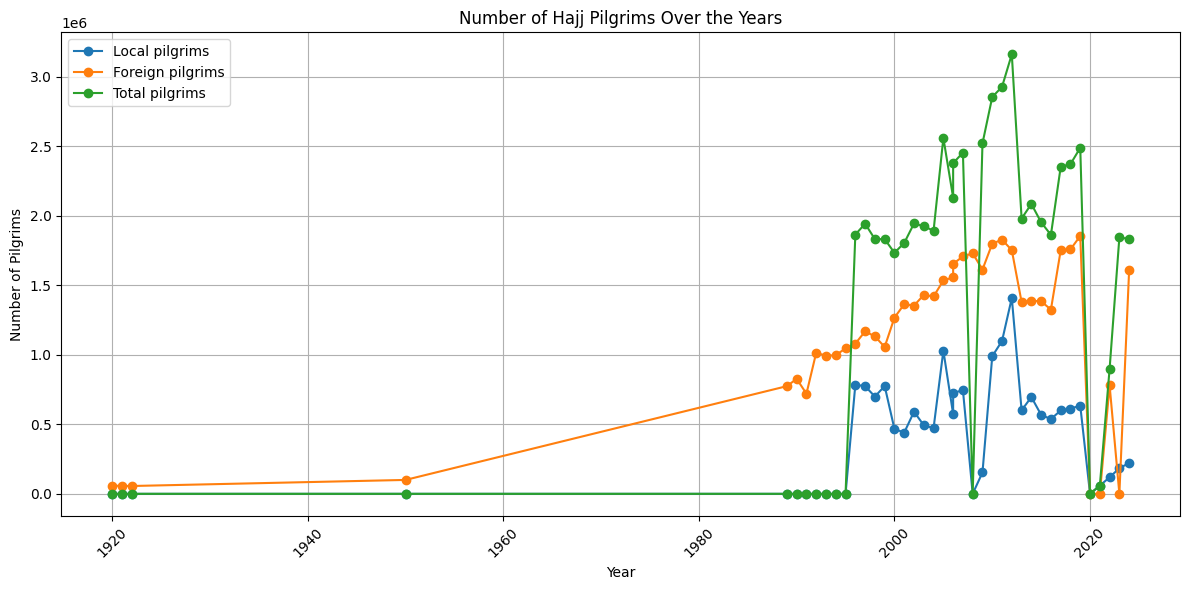

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# رسم كل نوع من الحجاج بلون مختلف
plt.plot(df['Gregorian_year_date'], df['Local pilgrims'], marker='o', label='Local pilgrims')
plt.plot(df['Gregorian_year_date'], df['Foreign pilgrims'], marker='o', label='Foreign pilgrims')
plt.plot(df['Gregorian_year_date'], df['Total'], marker='o', label='Total pilgrims')

# إعدادات الرسم
plt.xlabel('Year')
plt.ylabel('Number of Pilgrims')
plt.title('Number of Hajj Pilgrims Over the Years')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # تدوير سنوات x لتكون مقروءة
plt.tight_layout()       # لتجنب قص العناوين

# عرض الرسم
plt.show()
